# TP2 CORRECTION : apprentissage supervisé
    cours: Master SIAD
    date: 25.10.2019
    @: vasseur.corentin@gmail.com


In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from utils_titanic import plot_confusion_matrix

# PARTIE I :

## Exercice 1:

    1. Chargement des données et calculs des valeurs manquantes

In [2]:
path = '../titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

    2. Choix de stratégie d'imputation des valeurs manquantes

Pclass = 1: age moyen -> 38.23
Pclass = 2: age moyen -> 29.88
Pclass = 3: age moyen -> 25.14


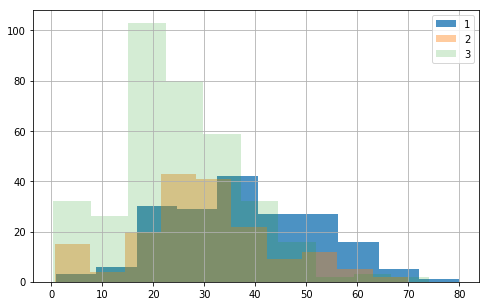

In [4]:
# Analyse croisée entre l'age 
fig, ax = plt.subplots(1,1,figsize=(8,5))
train.loc[train.Pclass == 1, 'Age'].hist(alpha=0.8,ax=ax)
train.loc[train.Pclass == 2, 'Age'].hist(alpha=0.4,ax=ax)
train.loc[train.Pclass == 3, 'Age'].hist(alpha=0.2,ax=ax)
ax.legend(['1','2','3'])

print("Pclass = 1: age moyen ->",round(train.loc[train.Pclass == 1, 'Age'].mean(),2))
print("Pclass = 2: age moyen ->",round(train.loc[train.Pclass == 2, 'Age'].mean(),2))
print("Pclass = 3: age moyen ->",round(train.loc[train.Pclass == 3, 'Age'].mean(),2))

In [5]:
# choix pour l'Age : analyse croisée des valeurs manquantes pour la var Age (avec Pclass)
train.loc[train.Pclass == 1, 'Age'] = \
            train[train.Pclass == 1].Age.fillna(train.loc[train.Pclass == 1, 'Age'].mean())

train.loc[train.Pclass == 2, 'Age'] = \
            train[train.Pclass == 2].Age.fillna(train.loc[train.Pclass == 2, 'Age'].mean())

train.loc[train.Pclass == 3, 'Age'] = \
            train[train.Pclass == 3].Age.fillna(train.loc[train.Pclass == 3, 'Age'].mean())

# Une recherche sur internet des noms des passagers nous donne l'info: 'S'
# -> https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
# -> https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
train.Embarked.fillna('S', inplace=True)

    3. Valeurs aberrantes/extrêmes

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11226f898>,
      dtype=object)

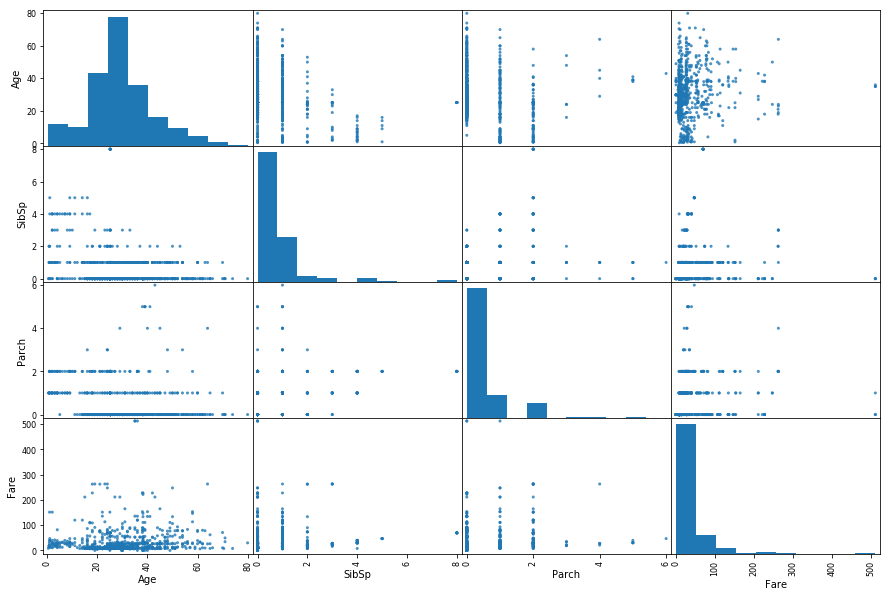

In [6]:
# example de scatter plot afin de détecter d'éventuelles valeurs aberrantes/extrêmes
fig, ax = plt.subplots(1,1, figsize=(15,10))
pd.plotting.scatter_matrix(train[['Age', 'SibSp', 'Parch', 'Fare']], \
                           diagonal='hist',
                           alpha=0.8, ax=ax)

Text(0.5, 1.0, 'After outliers replaced')

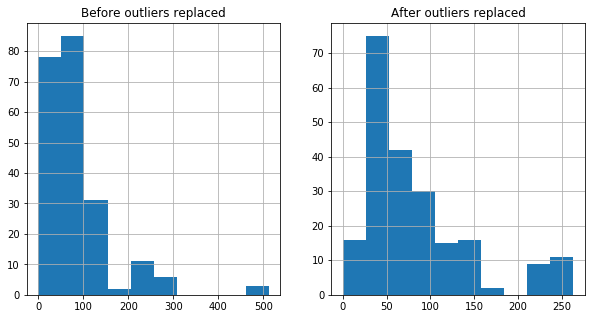

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
# Variable Fare possédent 2 valeurs aberrantes a priori : nous faisons le choix ainsi de les remplacer par le max
train[train.Pclass==1].Fare.hist(ax=ax[0])
ax[0].set_title('Before outliers replaced')

# remplacement par le max de Pclass
maxi = train[(train.Pclass==1)&(train.Fare<500)].Fare.max()
train.Fare = train.Fare.replace(512.3292, maxi)
train[train.Pclass==1].Fare.hist(ax=ax[1])
ax[1].set_title('After outliers replaced')

In [8]:
train.isnull().sum()

# choix de supprimer la variable cabin (cf. notebooks TP2 - exercice bonus)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## Exercice 2 :

In [9]:
# selection de variable 
categorical_cols = ['Sex', 'Embarked','Pclass']
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
my_cols = categorical_cols + numeric_cols
target = 'Survived'

X, y = train[my_cols], train[target]

In [10]:
# one Hot Encoding / get_dummies
X = pd.get_dummies(X, columns=categorical_cols)
X.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [11]:
# split train, valid
X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.33, random_state=4)

my_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']

X_train = X_train[my_cols]
X_valid = X_valid[my_cols]

In [12]:
X_train.head()

,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
879,56.0,0,1,83.1583,1,1,0,0,1,0,0
523,44.0,0,1,57.9792,1,1,0,0,1,0,0
585,18.0,0,2,79.6500,1,0,0,1,1,0,0
436,21.0,2,2,34.3750,1,0,0,1,0,0,1
212,22.0,0,0,7.2500,0,0,0,1,0,0,1


# PARTIE II : Modélisation

In [13]:
# Etude d'un hyperparametre de l'arbre de decision (profondeur de l'arbre)
res = list()
res_valid = list()
for i in range(1,30):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    res.append(model.score(X_train, y_train))
    res_valid.append(model.score(X_valid, y_valid))

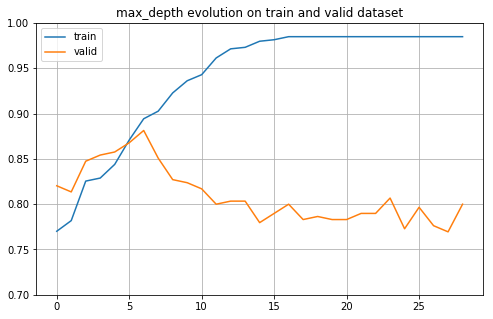

In [14]:
# plot les performances (accuracy score) for different depth of decision tree
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(res)
ax.plot(res_valid)
ax.set_ylim(0.7,1)
ax.legend(['train','valid'])
ax.set_title('max_depth evolution on train and valid dataset')
plt.grid(True)

In [15]:
# On choisit une profondeur de 6
model = DecisionTreeClassifier(max_depth=6)
model.fit(X_train, y_train)

# Prediction 
y_pred_train = model.predict_proba(X_train)
y_pred_valid = model.predict_proba(X_valid)

# Train probability prediction
y_pred_train = y_pred_train[:, 1]
y_pred_valid = y_pred_valid[:, 1]

Text(0.5, 1.0, 'Precision / Recall curve')

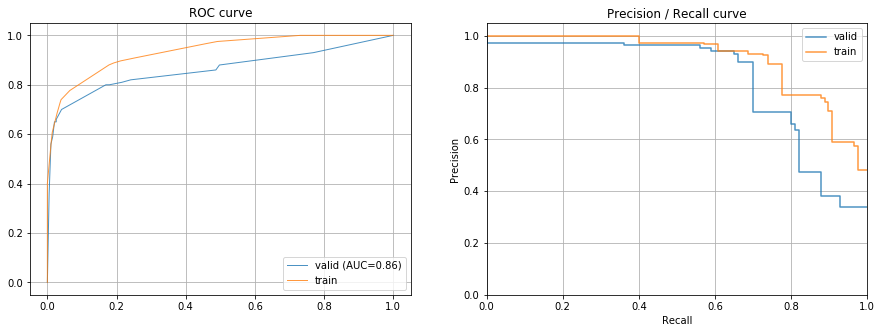

In [16]:
# ROC - Precision/recall curves

fig, ax = plt.subplots(1,2,figsize=(15,5))

#valid
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
auc =  round(roc_auc_score(y_valid, y_pred_valid),2)

#train
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)

fpr_train, tpr_train, thresholds = roc_curve(y_train, y_pred_train)

ax[0].plot(fpr, tpr, lw=1, alpha=0.8)
ax[0].plot(fpr_train, tpr_train, lw=1, alpha=0.8)
ax[0].grid(True)
ax[0].legend(['valid (AUC='+str(auc)+')', 'train'])
ax[0].set_title('ROC curve')

# Precision / Recall performance
precision, recall, _ = precision_recall_curve(y_valid, y_pred_valid)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train)

ax[1].step(recall, precision, alpha=0.8,
         where='post')
ax[1].step(recall_train, precision_train, alpha=0.8,
         where='post')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlim([0.0, 1.0])
ax[1].grid(True)
ax[1].legend(['valid','train'])
ax[1].set_title('Precision / Recall curve')

Confusion matrix, without normalization
[[187   8]
 [ 30  70]]


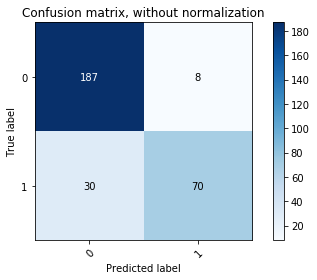

In [17]:
# choix d'un seuil et affichage de la matrice de confusion
t = thresholds[precision>0.8][0]
y_pred_t = [1 if i > t else 0 for i in y_pred_valid]
plot_confusion_matrix(list(y_valid.values), list(y_pred_t), normalize=False)

# PARTIE III : Comparaison de deux modèles

## Exercice 5: comparaison avec un RandomForest

In [18]:
# utilisation de la fonction GridSearch permettant de tester differents hyperparametres à l'aide de la validation croisée
# warning: temps d'execution important 

param_grid = {'bootstrap': [True, False],
 'max_depth': [5,10,30,50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5,10,30,50, 100]}

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
gs.fit(X_valid, y_valid)
gs.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [21]:
# choisit le résultat de gridsearch
rf = RandomForestClassifier(bootstrap= True,
 max_depth= 50,
 max_features= 'auto',
 min_samples_leaf= 4,
 min_samples_split= 2,
 n_estimators= 30)
rf.fit(X_train, y_train)

# Prediction 
y_pred_train_rf = rf.predict_proba(X_train)
y_pred_valid_rf = rf.predict_proba(X_valid)

# Train probability prediction
y_pred_train_rf = y_pred_train_rf[:, 1]
y_pred_valid_rf = y_pred_valid_rf[:, 1]

    1. Etude des performances du RandomForestClassifier 

Text(0.5, 1.0, 'Precision / Recall curve')

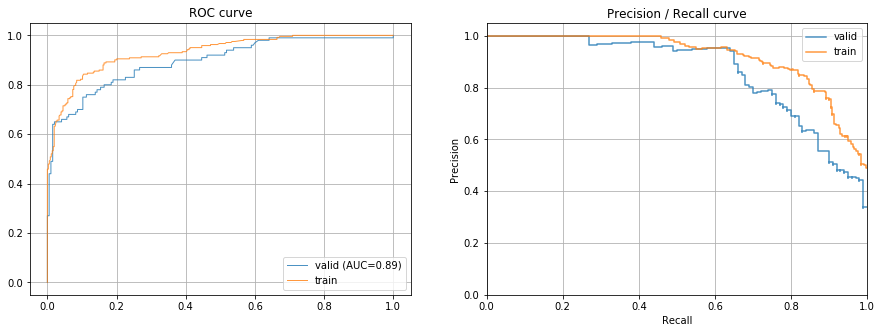

In [22]:
# ROC - Precision/recall curves

fig, ax = plt.subplots(1,2,figsize=(15,5))

#valid
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid_rf)
auc =  round(roc_auc_score(y_valid, y_pred_valid_rf),2)

#train
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_pred_train_rf)

ax[0].plot(fpr, tpr, lw=1, alpha=0.8)
ax[0].plot(fpr_train, tpr_train, lw=1, alpha=0.8)
ax[0].grid(True)
ax[0].legend(['valid (AUC='+str(auc)+')', 'train'])
ax[0].set_title('ROC curve')

# Precision / Recall performance

precision_rf, recall_rf, _ = precision_recall_curve(y_valid, y_pred_valid_rf)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train_rf)

ax[1].step(recall_rf, precision_rf, alpha=0.8,
         where='post')
ax[1].step(recall_train, precision_train, alpha=0.8,
         where='post')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlim([0.0, 1.0])
ax[1].grid(True)
ax[1].legend(['valid','train'])
ax[1].set_title('Precision / Recall curve')

    2. Comparaison des deux modèles : DecisionTreeClassifier et RandomForestClassifier

Text(0.5, 1.0, 'Precision / Recall curve')

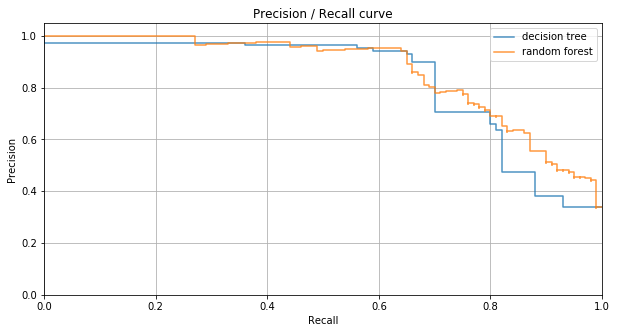

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# Precision / Recall performance
auc_rf =  round(roc_auc_score(y_valid, y_pred_valid_rf),2)
auc_dt =  round(roc_auc_score(y_valid, y_pred_valid),2)

ax.step(recall, precision, alpha=0.8, where='post')
ax.step(recall_rf, precision_rf, alpha=0.8, where='post')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.grid(True)
ax.legend(['decision tree','random forest'])
ax.set_title('Precision / Recall curve')